# Evaluation of the quantized model

After quantizing the model we can evaluate the results on the test subset. We have already run the quantized model inference over the test samples and saved the predictions in a h5 file. Now we can load these predictions and compare them against ground truth labels to obtain the metrics.

In [1]:
from pathlib import Path

import h5py
import matplotlib as mpl
import torch
from matplotlib import pyplot as plt
from torchmetrics.functional.classification.jaccard import jaccard_index
from tqdm import tqdm

from sml_tutorials_ml_deployment.datasets import DeepGlobeLandCover, make_classes_legend, normalize_cmap, transforms
from sml_tutorials_ml_deployment.training import make_segmentation_metrics_collection

%config InlineBackend.figure_format = "retina"

We will use the test dataset to load the ground truth labels.

In [2]:
test_ds = DeepGlobeLandCover(root_dir=Path("../../dataset/deep_globe_patched"), split="test", transforms=transforms)
num_classes = len(test_ds.CLASSES)

In [3]:
# Colormap and legend for classes
classes_legend = make_classes_legend(test_ds.COLORMAP, test_ds.CLASSES)
cmap = mpl.colors.ListedColormap(normalize_cmap(test_ds.COLORMAP))

We can use the same set of metrics that we utilized right after the model training.

In [4]:
metrics = make_segmentation_metrics_collection(num_classes=num_classes)

In [5]:
with h5py.File("../../output/03-quantize/quantization_test_preds.h5", "r") as f:
    for test_sample in tqdm(test_ds):
        sample_name = test_sample["id"]
        pred = torch.as_tensor(f[sample_name])
        target = test_sample["mask"]
        # Inputs must be batched
        metrics.update(pred, target.unsqueeze(0))

metrics.compute()

  0%|          | 0/3000 [00:00<?, ?it/s]/tmp/ipykernel_541248/3212483649.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  pred = torch.as_tensor(f[sample_name])
100%|██████████| 3000/3000 [12:00<00:00,  4.16it/s]


{'dice_macro': tensor(0.7986),
 'dice_micro': tensor(0.8382),
 'jaccard_macro': tensor(0.6900),
 'jaccard_micro': tensor(0.7215)}

Finally we can preview the results by glancing over the demo sample.

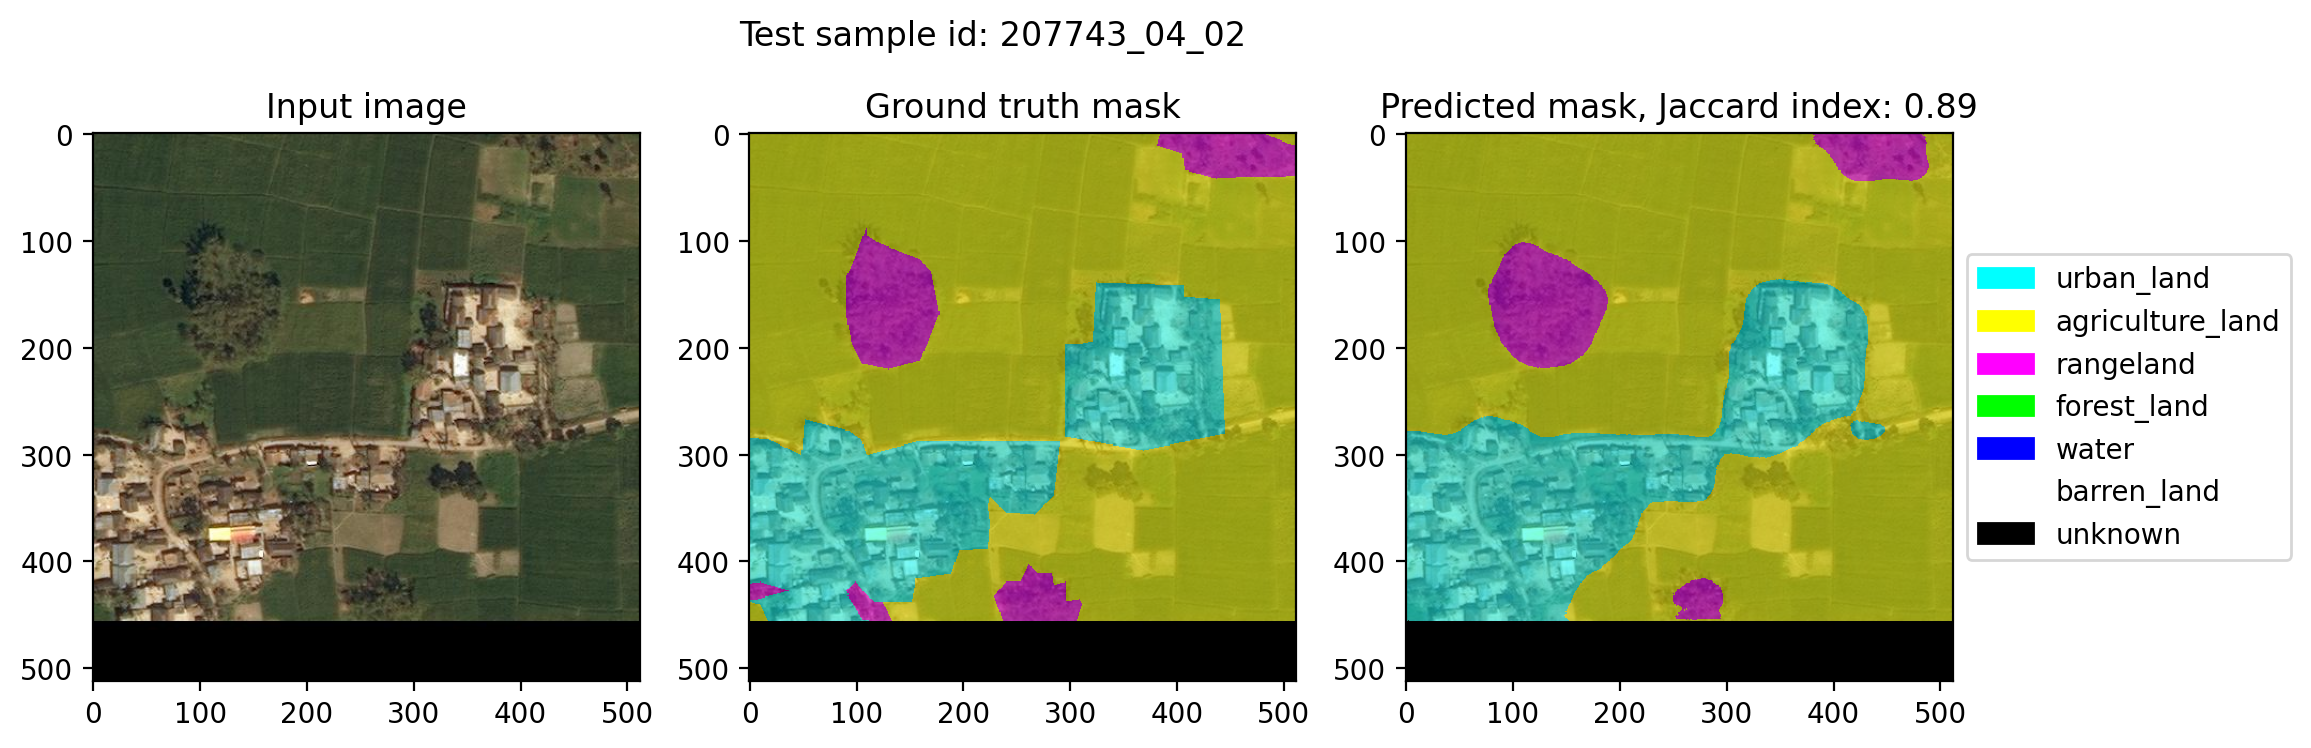

In [6]:
test_sample = test_ds[2472]
test_input = test_sample["image"]
test_mask = test_sample["mask"]

with h5py.File("../../output/03-quantize/quantization_test_preds.h5", "r") as f:
    pred_sample = torch.as_tensor(f[test_sample["id"]])
pred_sample_cls = pred_sample.squeeze(0).argmax(dim=0).long()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_input.permute(1, 2, 0))
plt.title("Input image")

plt.subplot(1, 3, 2)
plt.imshow(test_input.permute(1, 2, 0))
plt.imshow(test_mask, alpha=0.5, cmap=cmap, vmin=0, vmax=num_classes, interpolation="nearest")
plt.title("Ground truth mask")

plt.subplot(1, 3, 3)
plt.imshow(test_input.permute(1, 2, 0))
plt.imshow(pred_sample_cls, alpha=0.5, cmap=cmap, vmin=0, vmax=num_classes, interpolation="nearest")
plt.title("Predicted mask, Jaccard index: {:.2f}".format(jaccard_index(pred_sample_cls, test_mask, task="multiclass", num_classes=num_classes, average="micro")))

plt.suptitle(f"Test sample id: {test_sample['id']}")
plt.legend(classes_legend, test_ds.CLASSES, loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()